# MMI 1 x 4 power splitter

Run this notebook in your browser using [Binder](https://mybinder.org/v2/gh/flexcompute-readthedocs/tidy3d-docs/readthedocs?labpath=docs%2Fsource%2Fnotebooks%2FMMI_1by4.ipynb).

Optical power splitters are essential components in integrated photonics. Power splitters based on multimode interference (MMI) device are easy to fabricate and can achieve low excess loss as well as large bandwidth. Although the design of a MMI power splitter is based on the self-imaging principle, fine-tuning the geometric parameters with accurate and fast numerical simulations is crucial to achieving optimal device performance. 

This example aims to demonstrate the design and optimization of 1 to 4 MMI device at telecom wavelength for power splitting applications. The initial design is adapted from [D. Malka, Y. Danan, Y. Ramon, Z. Zalevsky, A Photonic 1 x 4 Power Splitter Based on Multimode Interference in Silicon–Gallium-Nitride Slot Waveguide Structures. Materials. 9, 516 (2016)](https://www.mdpi.com/1996-1944/9/7/516).

The device uses a Si-GaN-Si slot waveguide structure as schematically shown below.

<img src="img/AdjointMMI.png" width=500>


## Simulation Setup 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tidy3d as td
import tidy3d.web as web
import jax
from jax.lax import stop_gradient
from tidy3d.plugins.adjoint import JaxSimulation, JaxBox, JaxMedium, JaxStructure, JaxSimulationData
from tidy3d.plugins.adjoint.web import run

from tidy3d.plugins import ModeSolver

[15:32:56] WARNING  This version of Tidy3D was pip installed from the 'tidy3d-beta' repository on   ]8;id=322197;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/__init__.py\__init__.py]8;;\:]8;id=780626;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/__init__.py#103\103]8;;\
                    PyPI. Future releases will be uploaded to the 'tidy3d' repository. From now on,                
                    please use 'pip install tidy3d' instead.                                                       

           INFO     Using client version: 1.9.0                                                     ]8;id=831760;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/__init__.py\__init__.py]8;;\:]8;id=645322;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/__init__.py#121\121]8;;\

Define materials

In [2]:
med = td.Medium(permittivity=1.2**2)

Define initial design parameters and wrap simulation setup in a function. The arguments of the function are the parameters we want to optimize later. In this example, we aim to optimize the length and width of the MMI section.

In [3]:
W_MMI0 = 12.0  # width of the MMI section
L_MMI0 = 12.0  # length of the MMI section

wg_width = 0.7
wg_spc = 1.5

lda0 = 1.55   #central wavelength
freq0 = td.C_0/lda0  #central frequency
ldas = np.array([lda0])   #wavelength range
freqs = td.C_0/ldas  #frequency range

#buffer spacings in the x and y directions.
buffer_x = 4
buffer_y = 4.5

#define a function that takes the geometric parameters as input arguments and returns a Simulation object
def make_sim(L_MMI=L_MMI0, W_MMI=W_MMI0):
    #the whole device is defined as a PolySlab with vertices given by the following

    # L_MMI0 = stop_gradient(L_MMI)
    # W_MMI0 = stop_gradient(W_MMI)
    
    #simulation domain size
    Lx = W_MMI0 + 2 * buffer_x
    Ly = L_MMI0 + 2 * buffer_y
    sim_size = (Lx, Ly, 0)
    
    wg_in = td.Structure(
        geometry=td.Box(
            size=(wg_width, Ly, td.inf),
            center=(0.0, -Ly/2, 0.0)),
        medium=med,
    )
    
    xl = wg_width/2.0 + wg_spc + wg_width + wg_spc/2.0
    xs = [-xl + i * (wg_width + wg_spc) for i in range(4)]
    wg_outs = [td.Structure(
        geometry=td.Box(
            size=(wg_width, Ly, td.inf),
            center=(x0, Ly/2, 0.0)),
        medium=med,
    ) for x0 in xs]


    mmi_box = JaxStructure(
        geometry=JaxBox(
            size=(W_MMI, L_MMI, td.inf),
            center=(0.0, 0.0, 0.0)),
        medium=JaxMedium(permittivity=med.permittivity)
    )


    mode_spec = td.ModeSpec(num_modes=1)
    mode_size = (td.inf, 0, td.inf)
    #add a mode source for excitation
    mode_source = td.ModeSource(
        center=(0, -Ly/2 + buffer_y/3, 0),
        size=mode_size,
        source_time = td.GaussianPulse(
            freq0=freq0,
            fwidth=freq0/10),
        direction='+',
        mode_spec=mode_spec,
        mode_index=0)
    
    #add two mode monitors to monitor the mode profiles at output waveguides
    mode_monitors = []
    for i, x0 in enumerate(xs):
        center = (x0, Ly/2 -buffer_y/3, 0)
        size = (wg_width + wg_spc, 0, td.inf)
        mode_monitors.append(
            td.ModeMonitor(
                center = center,
                size = size,
                freqs = freqs,
                mode_spec=mode_spec,
                name=f'mode_{i}'
            )       
        )

    #add a field monitor to monitor the field distribution
    field_monitor = td.FieldMonitor(
        center = (0,0,0),
        size = (td.inf, td.inf, 0),
        freqs = [freq0],
        name='field'
    )

    sim = JaxSimulation(
            center=(0,0,0),
            size=sim_size,
            grid_spec=td.GridSpec.uniform(dl=0.01),
            structures=[wg_in] + wg_outs,
            input_structures=[mmi_box],
            sources=[mode_source],
            monitors=[field_monitor],
            output_monitors=mode_monitors,
            run_time=3e-11,
            shutoff=1e-8,
            boundary_spec=td.BoundarySpec.pml(x=True, y=True, z=False),
    )
    return sim

## Initial Design

First, we simulate an initial design using the previously defined design parameters.

[15:32:57] WARNING  'BoundarySpec.z' uses default value, which is 'Periodic()' but will change to   ]8;id=157935;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/components/boundary.py\boundary.py]8;;\:]8;id=806110;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/components/boundary.py#607\607]8;;\
                    'PML()' in Tidy3D version 2.0. We recommend explicitly setting all boundary                    
                    conditions ahead of this release to avoid unexpected results.                                  

<AxesSubplot: title={'center': 'cross section at y=-1.50'}, xlabel='x', ylabel='z'>

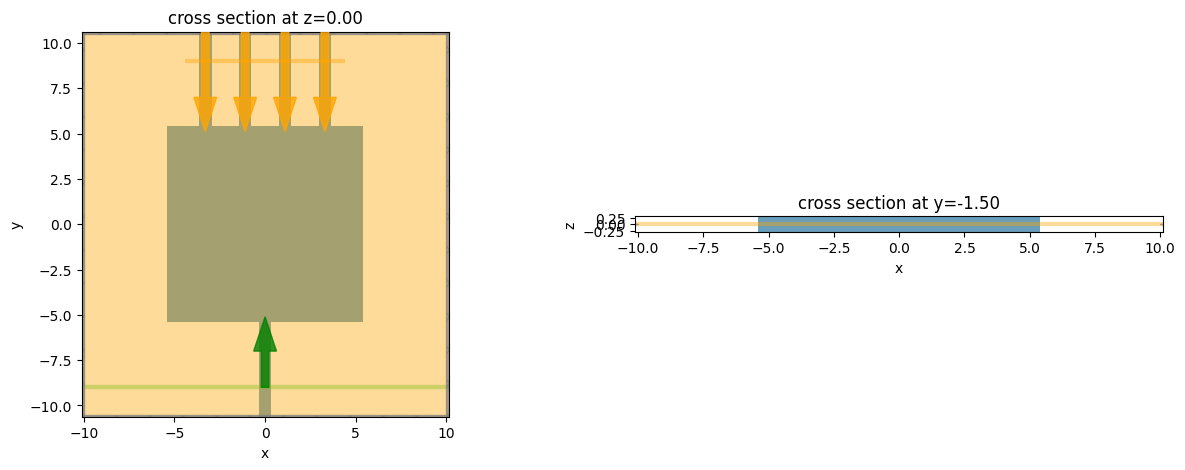

In [4]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
sim = make_sim(L_MMI0*0.9, W_MMI0*0.9)
sim.plot(z=0, ax=ax1)
sim.plot(y=-buffer_y/3, ax=ax2)


Before simulation, let's inspect the waveguide modes supported in the slot waveguide to make sure we are using the correct excitation source. 

In [5]:
mode_spec = td.ModeSpec(num_modes=2)

mode_solver = ModeSolver(
    simulation=sim,
    plane=sim.output_monitors[0].geometry,
    mode_spec=mode_spec,
    freqs=[freq0],
)
mode_data = mode_solver.solve()

/Users/twhughes/.pyenv/versions/3.10.9/lib/python3.10/site-packages/numpy/linalg/linalg.py:2139: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/twhughes/.pyenv/versions/3.10.9/lib/python3.10/site-packages/numpy/linalg/linalg.py:2139: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


The lowest order mode shows a strong field confinement between the Si area. This is the mode we want to use as excitation.

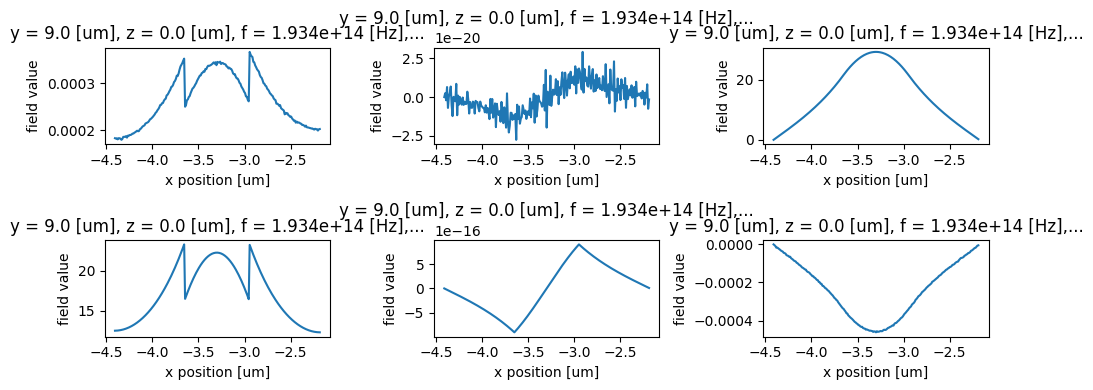

In [6]:
num_modes = mode_spec.num_modes

f, axes_all = plt.subplots(num_modes, 3, tight_layout=True, figsize=(10, 2*num_modes))
for mode_index, (ax_ex, ax_ey, ax_ez) in zip(range(num_modes), axes_all):
    mode_data.Ex.real.isel(mode_index=mode_index).plot(ax=ax_ex)
    mode_data.Ey.real.isel(mode_index=mode_index).plot(ax=ax_ey)
    mode_data.Ez.real.isel(mode_index=mode_index).plot(ax=ax_ez)

plt.show()

Submit simulation job to the server. 

In [7]:
sim = make_sim(L_MMI0, W_MMI0).to_simulation()[0]
job = web.Job(simulation=sim, task_name='mmi')
sim_data = job.run(path='data/simulation_data.hdf5')

[15:32:58] WARNING  'BoundarySpec.z' uses default value, which is 'Periodic()' but will change to   ]8;id=43936;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/components/boundary.py\boundary.py]8;;\:]8;id=633818;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/components/boundary.py#607\607]8;;\
                    'PML()' in Tidy3D version 2.0. We recommend explicitly setting all boundary                    
                    conditions ahead of this release to avoid unexpected results.                                  

[15:32:59] INFO     Created task 'mmi' with task_id '38dfc239-3a76-41ef-b815-f25937a3406e'.           ]8;id=897676;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=457502;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#120\120]8;;\

Output()

[15:33:02] INFO     Maximum FlexUnit cost: 2.151                                                      ]8;id=710039;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=595346;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#253\253]8;;\

           INFO     status = queued                                                                   ]8;id=787215;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=840477;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#262\262]8;;\

Output()

[15:33:05] INFO     status = preprocess                                                               ]8;id=588202;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=479597;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#274\274]8;;\

[15:33:10] INFO     starting up solver                                                                ]8;id=756066;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=744730;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#278\278]8;;\

[15:33:20] INFO     running solver                                                                    ]8;id=994373;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=493610;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#284\284]8;;\

Output()

[15:33:52] INFO     early shutoff detected, exiting.                                                  ]8;id=416830;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=758768;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#295\295]8;;\

           INFO     status = postprocess                                                              ]8;id=904691;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=522283;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#301\301]8;;\

Output()

[15:34:21] INFO     status = success                                                                  ]8;id=183260;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=82720;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#307\307]8;;\

[15:34:22] INFO     Billed FlexUnit cost: 0.088                                                       ]8;id=297184;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=949684;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#311\311]8;;\

           INFO     downloading file "output/monitor_data.hdf5" to "data/simulation_data.hdf5"        ]8;id=915470;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=819363;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#593\593]8;;\

Output()

[15:34:46] INFO     loading SimulationData from data/simulation_data.hdf5                             ]8;id=726197;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=190615;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#415\415]8;;\

Visualize the field distribution.

<AxesSubplot: title={'center': 'cross section at z=0.00'}, xlabel='x', ylabel='y'>

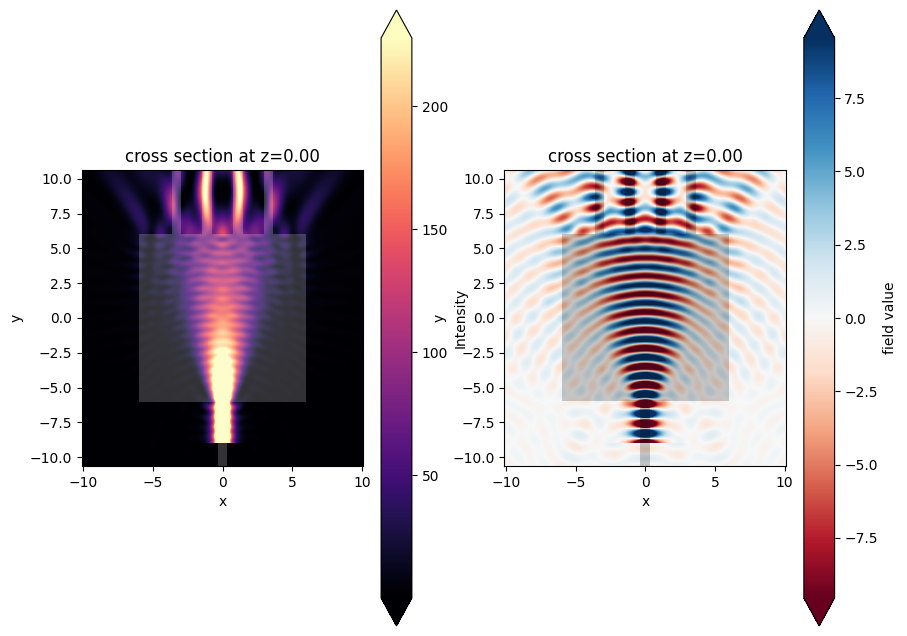

In [8]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,8))
sim_data.plot_field('field', 'int', ax = ax1, f=freq0)
sim_data.plot_field('field', 'Ez', ax = ax2, f=freq0)

## Optimization 

Further tuning of the geometric parameters is likely to improve the device's performance further. We will perform a parameter sweep on two parameters to see if we can optimize the MMI. The goal is to achieve even power splitting among output waveguides while keeping the excess loss low.

The length of the MMI is swept from 11.1 to 11.2 $\mu m$ in 50 nm step and the width from 4.8 to 5 $\mu m$ in 100 nm step. This results in a total of 9 simulations. Since this is just a demonstration model, we limit the total number of simulations for the sake of time. In practice, one can perform much larger parameter sweeps to cover a larger parameter space.


In [9]:
import jax.numpy as jnp


def objective(L_MMI, W_MMI, step_num: int = None, J_val: float=None):
    """Get the total power in each output waveguide as a function of MMI length and width."""
    
    # make a custom task_name for this iteration, to help keep track of progress
    if step_num and J_val:
        task_name = f"MMI_step{step_num}_J={J_val:.2e}"
    else:
        task_name = "MMI"

    # generate and run simulation with adjoint plugin
    sim = make_sim(L_MMI, W_MMI)
    sim_data = run(sim, task_name=task_name)
    
    # post process the ModeData to add up all power
    total_power = 0.0
    for i in range(4):
        monitor_name = f'mode_{i}'
        amp = sim_data[monitor_name].amps.sel(direction="+", f=freq0, mode_index=0)
        power = abs(amp)**2
        total_power = total_power + power

    return total_power

In [10]:
val_and_grad_objective = jax.value_and_grad(objective, argnums=(0,1))

In [11]:
J, (dL, dW) = val_and_grad_objective(L_MMI0, W_MMI0)

[15:34:53] WARNING  'BoundarySpec.z' uses default value, which is 'Periodic()' but will change to   ]8;id=63390;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/components/boundary.py\boundary.py]8;;\:]8;id=561419;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/components/boundary.py#607\607]8;;\
                    'PML()' in Tidy3D version 2.0. We recommend explicitly setting all boundary                    
                    conditions ahead of this release to avoid unexpected results.                                  

           INFO     Remote TPU is not linked into jax; skipping remote TPU.                       ]8;id=743208;file:///Users/twhughes/.pyenv/versions/3.10.9/lib/python3.10/site-packages/jax/_src/lib/xla_bridge.py\xla_bridge.py]8;;\:]8;id=5338;file:///Users/twhughes/.pyenv/versions/3.10.9/lib/python3.10/site-packages/jax/_src/lib/xla_bridge.py#160\160]8;;\

           INFO     Unable to initialize backend 'tpu_driver': Could not initialize backend       ]8;id=739148;file:///Users/twhughes/.pyenv/versions/3.10.9/lib/python3.10/site-packages/jax/_src/lib/xla_bridge.py\xla_bridge.py]8;;\:]8;id=415929;file:///Users/twhughes/.pyenv/versions/3.10.9/lib/python3.10/site-packages/jax/_src/lib/xla_bridge.py#333\333]8;;\
                    'tpu_driver'                                                                                   

           INFO     Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no     ]8;id=745609;file:///Users/twhughes/.pyenv/versions/3.10.9/lib/python3.10/site-packages/jax/_src/lib/xla_bridge.py\xla_bridge.py]8;;\:]8;id=77307;file:///Users/twhughes/.pyenv/versions/3.10.9/lib/python3.10/site-packages/jax/_src/lib/xla_bridge.py#333\333]8;;\
                    attribute 'GpuAllocatorConfig'                                                                 

           INFO     Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no     ]8;id=633442;file:///Users/twhughes/.pyenv/versions/3.10.9/lib/python3.10/site-packages/jax/_src/lib/xla_bridge.py\xla_bridge.py]8;;\:]8;id=424946;file:///Users/twhughes/.pyenv/versions/3.10.9/lib/python3.10/site-packages/jax/_src/lib/xla_bridge.py#333\333]8;;\
                    attribute 'GpuAllocatorConfig'                                                                 

           INFO     Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no      ]8;id=789660;file:///Users/twhughes/.pyenv/versions/3.10.9/lib/python3.10/site-packages/jax/_src/lib/xla_bridge.py\xla_bridge.py]8;;\:]8;id=317168;file:///Users/twhughes/.pyenv/versions/3.10.9/lib/python3.10/site-packages/jax/_src/lib/xla_bridge.py#333\333]8;;\
                    attribute 'get_tpu_client'                                                                     

[15:34:54] INFO     Created task 'MMI_fwd' with task_id 'ce9924af-639d-439a-8f81-8652713e5aca'.       ]8;id=163872;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=688001;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#120\120]8;;\

Output()

[15:34:57] INFO     Maximum FlexUnit cost: 2.255                                                      ]8;id=34046;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=320149;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#253\253]8;;\

           INFO     status = queued                                                                   ]8;id=672758;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=867077;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#262\262]8;;\

Output()

[15:35:00] INFO     status = preprocess                                                               ]8;id=201013;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=891201;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#274\274]8;;\

[15:35:04] INFO     starting up solver                                                                ]8;id=497717;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=274120;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#278\278]8;;\

[15:35:15] INFO     running solver                                                                    ]8;id=121011;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=150921;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#284\284]8;;\

Output()

[15:35:47] INFO     early shutoff detected, exiting.                                                  ]8;id=486879;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=138442;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#295\295]8;;\

           INFO     status = postprocess                                                              ]8;id=175499;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=647184;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#301\301]8;;\

Output()

[15:36:24] INFO     status = success                                                                  ]8;id=53259;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=249810;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#307\307]8;;\

           INFO     Billed FlexUnit cost: 0.092                                                       ]8;id=736730;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=734438;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#311\311]8;;\

[15:36:25] INFO     downloading file "output/monitor_data.hdf5" to "simulation_data.hdf5"             ]8;id=343332;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=892693;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#593\593]8;;\

Output()

[15:36:52] INFO     loading SimulationData from simulation_data.hdf5                                  ]8;id=563052;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=432732;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#415\415]8;;\

[15:36:53] INFO     Created task 'MMI_adj' with task_id 'a3e58a71-03ac-48c3-ba78-8eb585c4eff3'.       ]8;id=283437;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=443927;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#120\120]8;;\

Output()

[15:36:55] INFO     Maximum FlexUnit cost: 2.100                                                      ]8;id=905661;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=240246;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#253\253]8;;\

           INFO     status = queued                                                                   ]8;id=709586;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=140106;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#262\262]8;;\

Output()

[15:36:58] INFO     status = preprocess                                                               ]8;id=765523;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=170077;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#274\274]8;;\

[15:37:06] INFO     starting up solver                                                                ]8;id=817484;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=497919;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#278\278]8;;\

[15:37:17] INFO     running solver                                                                    ]8;id=529525;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=519011;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#284\284]8;;\

Output()

[15:37:36] INFO     early shutoff detected, exiting.                                                  ]8;id=354752;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=455372;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#295\295]8;;\

           INFO     status = postprocess                                                              ]8;id=445557;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=141405;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#301\301]8;;\

Output()

[15:37:50] INFO     status = success                                                                  ]8;id=770335;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=939252;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#307\307]8;;\

[15:37:51] INFO     Billed FlexUnit cost: 0.086                                                       ]8;id=714260;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=113863;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#311\311]8;;\

           INFO     downloading file "output/monitor_data.hdf5" to "simulation_data.hdf5"             ]8;id=734541;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=266062;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#593\593]8;;\

Output()

[15:38:02] INFO     loading SimulationData from simulation_data.hdf5                                  ]8;id=522613;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=558849;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#415\415]8;;\

In [12]:
print(J, (dL, dW))

0.66637117 (0.00023060059174895287, -0.03728976845741272)


Parse flux data into numpy arrays.

In [13]:
Js = [J]
args_history = [np.array((L_MMI0, W_MMI0))]

Js = []
def optimize(
    L_MMI,
    W_MMI,
    step_size=.5,
    num_steps=18,
    beta1=0.9,
    beta2=0.999,
    epsilon=1e-8,
):
    
    args = np.array([L_MMI, W_MMI])
    mt = np.zeros_like(args)
    vt = np.zeros_like(args)

    for i in range(num_steps):

        t = i + 1
        print(f'step = {t}')

        objective_value, gradient = val_and_grad_objective(*args, step_num=t)
        Js.append(objective_value)
        print(f'\tJ = {objective_value:.4e}')

        gradient = np.array(gradient).copy()
        print(f'\tgrad_norm = {np.linalg.norm(gradient):.4e}')

        mt = beta1 * mt + (1-beta1) * gradient
        vt = beta2 * vt + (1-beta2) * gradient**2

        mt_hat = mt / (1 - beta1**t)
        vt_hat = vt / (1 - beta2**t)

        update = step_size * (mt_hat / np.sqrt(vt_hat) + epsilon)
        args += update

        # handle case when the MMI width becomes less than the space between outer two edges of output waveguides
        min_width = 4 * wg_width + 3 * wg_spc
        if args[0] <= min_width:
            args[0] = min_width

        args_history.append(args.copy())

    return args

In [14]:
L_MMI_final, W_MMI_final = optimize(L_MMI0, W_MMI0)

step = 1


           WARNING  'BoundarySpec.z' uses default value, which is 'Periodic()' but will change to   ]8;id=320300;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/components/boundary.py\boundary.py]8;;\:]8;id=712070;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/components/boundary.py#607\607]8;;\
                    'PML()' in Tidy3D version 2.0. We recommend explicitly setting all boundary                    
                    conditions ahead of this release to avoid unexpected results.                                  

[15:38:03] INFO     Created task 'MMI_fwd' with task_id 'bd35cafa-6948-43eb-87f3-d3fd3069b45c'.       ]8;id=264159;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=607824;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#120\120]8;;\

Output()

[15:38:05] INFO     Maximum FlexUnit cost: 2.255                                                      ]8;id=775817;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=521514;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#253\253]8;;\

           INFO     status = queued                                                                   ]8;id=139610;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=953528;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#262\262]8;;\

Output()

[15:38:08] INFO     status = preprocess                                                               ]8;id=573135;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=825425;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#274\274]8;;\

[15:38:12] INFO     starting up solver                                                                ]8;id=290246;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=895896;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#278\278]8;;\

[15:38:23] INFO     running solver                                                                    ]8;id=388319;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=774117;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#284\284]8;;\

Output()

[15:38:56] INFO     early shutoff detected, exiting.                                                  ]8;id=26016;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=47164;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#295\295]8;;\

           INFO     status = postprocess                                                              ]8;id=238764;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=968787;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#301\301]8;;\

Output()

[15:39:32] INFO     status = success                                                                  ]8;id=991952;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=393897;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#307\307]8;;\

           INFO     Billed FlexUnit cost: 0.092                                                       ]8;id=792361;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=674481;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#311\311]8;;\

           INFO     downloading file "output/monitor_data.hdf5" to "simulation_data.hdf5"             ]8;id=611041;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=264946;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#593\593]8;;\

Output()

[15:40:00] INFO     loading SimulationData from simulation_data.hdf5                                  ]8;id=755803;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=592189;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#415\415]8;;\

[15:40:01] INFO     Created task 'MMI_adj' with task_id 'f5bf3b4d-0da0-40ad-b217-e4c114cbe3d6'.       ]8;id=450471;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=94309;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#120\120]8;;\

Output()

[15:40:03] INFO     Maximum FlexUnit cost: 2.100                                                      ]8;id=486023;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=567967;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#253\253]8;;\

           INFO     status = queued                                                                   ]8;id=67785;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=808436;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#262\262]8;;\

Output()

[15:40:06] INFO     status = preprocess                                                               ]8;id=747425;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=73297;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#274\274]8;;\

[15:40:11] INFO     starting up solver                                                                ]8;id=570003;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=908547;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#278\278]8;;\

[15:40:21] INFO     running solver                                                                    ]8;id=560129;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=473624;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#284\284]8;;\

Output()

[15:40:52] INFO     early shutoff detected, exiting.                                                  ]8;id=419627;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=637943;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#295\295]8;;\

           INFO     status = postprocess                                                              ]8;id=195598;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=52701;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#301\301]8;;\

Output()

[15:41:09] INFO     status = success                                                                  ]8;id=342929;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=13610;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#307\307]8;;\

[15:41:10] INFO     Billed FlexUnit cost: 0.086                                                       ]8;id=208906;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=880758;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#311\311]8;;\

           INFO     downloading file "output/monitor_data.hdf5" to "simulation_data.hdf5"             ]8;id=150200;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=35155;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#593\593]8;;\

Output()

[15:41:18] INFO     loading SimulationData from simulation_data.hdf5                                  ]8;id=273089;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=490097;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#415\415]8;;\

	J = 6.6637e-01
	grad_norm = 3.7290e-02
step = 2


[15:41:19] WARNING  'BoundarySpec.z' uses default value, which is 'Periodic()' but will change to   ]8;id=555858;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/components/boundary.py\boundary.py]8;;\:]8;id=631978;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/components/boundary.py#607\607]8;;\
                    'PML()' in Tidy3D version 2.0. We recommend explicitly setting all boundary                    
                    conditions ahead of this release to avoid unexpected results.                                  

           INFO     Created task 'MMI_fwd' with task_id 'a6ea69be-5a4e-4ecb-b0ee-f285d4f3ac3b'.       ]8;id=46327;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=659116;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#120\120]8;;\

Output()

[15:41:22] INFO     Maximum FlexUnit cost: 2.255                                                      ]8;id=253065;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=646682;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#253\253]8;;\

           INFO     status = queued                                                                   ]8;id=81480;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=900759;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#262\262]8;;\

Output()

[15:41:25] INFO     status = preprocess                                                               ]8;id=696829;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=601151;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#274\274]8;;\

[15:41:29] INFO     starting up solver                                                                ]8;id=802262;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=40327;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#278\278]8;;\

[15:41:39] INFO     running solver                                                                    ]8;id=57620;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=381062;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#284\284]8;;\

Output()

[15:42:12] INFO     early shutoff detected, exiting.                                                  ]8;id=537752;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=591770;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#295\295]8;;\

           INFO     status = postprocess                                                              ]8;id=580409;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=21593;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#301\301]8;;\

Output()

[15:42:52] INFO     status = success                                                                  ]8;id=304350;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=765665;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#307\307]8;;\

           INFO     Billed FlexUnit cost: 0.092                                                       ]8;id=547045;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=818762;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#311\311]8;;\

[15:42:53] INFO     downloading file "output/monitor_data.hdf5" to "simulation_data.hdf5"             ]8;id=269557;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=6134;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#593\593]8;;\

Output()

[15:43:20] INFO     loading SimulationData from simulation_data.hdf5                                  ]8;id=790021;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=959737;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#415\415]8;;\

[15:43:21] INFO     Created task 'MMI_adj' with task_id '8b8dfd75-c21e-4330-885d-a1e5ebe49d29'.       ]8;id=866345;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=603516;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#120\120]8;;\

Output()

[15:43:23] INFO     Maximum FlexUnit cost: 2.100                                                      ]8;id=652130;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=389268;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#253\253]8;;\

           INFO     status = queued                                                                   ]8;id=305856;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=831163;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#262\262]8;;\

Output()

[15:43:26] INFO     status = preprocess                                                               ]8;id=431534;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=314947;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#274\274]8;;\

[15:43:31] INFO     starting up solver                                                                ]8;id=608598;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=510950;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#278\278]8;;\

[15:43:41] INFO     running solver                                                                    ]8;id=417608;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=446237;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#284\284]8;;\

Output()

[15:44:14] INFO     early shutoff detected, exiting.                                                  ]8;id=960359;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=809952;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#295\295]8;;\

           INFO     status = postprocess                                                              ]8;id=212103;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=302671;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#301\301]8;;\

Output()

[15:44:29] INFO     status = success                                                                  ]8;id=708585;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=347710;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#307\307]8;;\

[15:44:30] INFO     Billed FlexUnit cost: 0.086                                                       ]8;id=102503;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=464283;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#311\311]8;;\

           INFO     downloading file "output/monitor_data.hdf5" to "simulation_data.hdf5"             ]8;id=133476;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=896623;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#593\593]8;;\

Output()

[15:44:38] INFO     loading SimulationData from simulation_data.hdf5                                  ]8;id=778105;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=504291;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#415\415]8;;\

	J = 6.8539e-01
	grad_norm = 8.5743e-02
step = 3


[15:44:39] WARNING  'BoundarySpec.z' uses default value, which is 'Periodic()' but will change to   ]8;id=125956;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/components/boundary.py\boundary.py]8;;\:]8;id=512670;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/components/boundary.py#607\607]8;;\
                    'PML()' in Tidy3D version 2.0. We recommend explicitly setting all boundary                    
                    conditions ahead of this release to avoid unexpected results.                                  

           INFO     Created task 'MMI_fwd' with task_id '66ab472b-9954-4c7e-9093-6f614cbf64ab'.       ]8;id=287458;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=869167;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#120\120]8;;\

Output()

[15:44:43] INFO     Maximum FlexUnit cost: 2.248                                                      ]8;id=951185;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=300204;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#253\253]8;;\

           INFO     status = queued                                                                   ]8;id=376658;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=501510;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#262\262]8;;\

Output()

[15:44:45] INFO     status = preprocess                                                               ]8;id=364400;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=916348;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#274\274]8;;\

[15:44:49] INFO     starting up solver                                                                ]8;id=461463;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=379470;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#278\278]8;;\

[15:44:59] INFO     running solver                                                                    ]8;id=343113;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=770962;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#284\284]8;;\

Output()

[15:45:32] INFO     early shutoff detected, exiting.                                                  ]8;id=251223;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=771056;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#295\295]8;;\

           INFO     status = postprocess                                                              ]8;id=50473;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=121088;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#301\301]8;;\

Output()

[15:46:22] INFO     status = success                                                                  ]8;id=579173;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=403047;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#307\307]8;;\

[15:46:23] INFO     Billed FlexUnit cost: 0.092                                                       ]8;id=634940;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=295163;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#311\311]8;;\

           INFO     downloading file "output/monitor_data.hdf5" to "simulation_data.hdf5"             ]8;id=225534;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=762988;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#593\593]8;;\

Output()

[15:46:49] INFO     loading SimulationData from simulation_data.hdf5                                  ]8;id=984521;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=830959;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#415\415]8;;\

[15:46:50] INFO     Created task 'MMI_adj' with task_id '8f5c1b33-320b-4178-b8d7-7124f33f1dc0'.       ]8;id=955114;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=731442;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#120\120]8;;\

Output()

[15:46:52] INFO     Maximum FlexUnit cost: 2.092                                                      ]8;id=514901;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=592795;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#253\253]8;;\

           INFO     status = queued                                                                   ]8;id=617037;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=277573;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#262\262]8;;\

Output()

[15:46:55] INFO     status = preprocess                                                               ]8;id=11688;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=341200;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#274\274]8;;\

[15:47:00] INFO     starting up solver                                                                ]8;id=723737;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=82194;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#278\278]8;;\

[15:47:10] INFO     running solver                                                                    ]8;id=274209;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=865949;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#284\284]8;;\

Output()

[15:47:43] INFO     early shutoff detected, exiting.                                                  ]8;id=880620;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=167732;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#295\295]8;;\

           INFO     status = postprocess                                                              ]8;id=295501;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=439872;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#301\301]8;;\

Output()

[15:47:58] INFO     status = success                                                                  ]8;id=549108;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=438468;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#307\307]8;;\

           INFO     Billed FlexUnit cost: 0.085                                                       ]8;id=249024;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=905294;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#311\311]8;;\

           INFO     downloading file "output/monitor_data.hdf5" to "simulation_data.hdf5"             ]8;id=210129;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=743449;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#593\593]8;;\

Output()

[15:48:09] INFO     loading SimulationData from simulation_data.hdf5                                  ]8;id=468836;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=957340;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#415\415]8;;\

	J = 6.9757e-01
	grad_norm = 4.4527e-02
step = 4


           WARNING  'BoundarySpec.z' uses default value, which is 'Periodic()' but will change to   ]8;id=205855;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/components/boundary.py\boundary.py]8;;\:]8;id=655267;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/components/boundary.py#607\607]8;;\
                    'PML()' in Tidy3D version 2.0. We recommend explicitly setting all boundary                    
                    conditions ahead of this release to avoid unexpected results.                                  

[15:48:10] INFO     Created task 'MMI_fwd' with task_id 'dbcf62c4-a7e1-43b6-962c-836eacf719db'.       ]8;id=976857;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=15470;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#120\120]8;;\

Output()

[15:48:12] INFO     Maximum FlexUnit cost: 2.245                                                      ]8;id=52023;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=181200;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#253\253]8;;\

           INFO     status = queued                                                                   ]8;id=180336;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=985181;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#262\262]8;;\

Output()

[15:48:15] INFO     status = preprocess                                                               ]8;id=145536;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=247755;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#274\274]8;;\

[15:48:22] INFO     starting up solver                                                                ]8;id=668694;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=16321;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#278\278]8;;\

[15:48:32] INFO     running solver                                                                    ]8;id=908697;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=800461;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#284\284]8;;\

Output()

[15:48:49] INFO     early shutoff detected, exiting.                                                  ]8;id=799818;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=680812;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#295\295]8;;\

           INFO     status = postprocess                                                              ]8;id=45236;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=977120;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#301\301]8;;\

Output()

[15:49:29] INFO     status = success                                                                  ]8;id=810099;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=435724;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#307\307]8;;\

           INFO     Billed FlexUnit cost: 0.092                                                       ]8;id=370403;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=240396;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#311\311]8;;\

           INFO     downloading file "output/monitor_data.hdf5" to "simulation_data.hdf5"             ]8;id=310449;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=233007;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#593\593]8;;\

Output()

[15:49:59] INFO     loading SimulationData from simulation_data.hdf5                                  ]8;id=305316;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=105750;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#415\415]8;;\

           INFO     Created task 'MMI_adj' with task_id 'aa441387-3ee6-4fe0-b66a-99641705dfca'.       ]8;id=658552;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=818338;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#120\120]8;;\

Output()

[15:50:02] INFO     Maximum FlexUnit cost: 2.089                                                      ]8;id=396057;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=511739;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#253\253]8;;\

           INFO     status = queued                                                                   ]8;id=336846;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=948821;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#262\262]8;;\

Output()

[15:50:05] INFO     status = preprocess                                                               ]8;id=489494;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=721238;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#274\274]8;;\

[15:50:12] INFO     starting up solver                                                                ]8;id=324700;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=55338;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#278\278]8;;\

[15:50:22] INFO     running solver                                                                    ]8;id=873169;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=862546;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#284\284]8;;\

Output()

           INFO     status = postprocess                                                              ]8;id=585407;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=75443;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#301\301]8;;\

Output()

[15:51:00] INFO     status = success                                                                  ]8;id=585565;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=12508;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#307\307]8;;\

           INFO     Billed FlexUnit cost: 0.085                                                       ]8;id=959092;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=589161;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#311\311]8;;\

[15:51:01] INFO     downloading file "output/monitor_data.hdf5" to "simulation_data.hdf5"             ]8;id=597270;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=794646;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#593\593]8;;\

Output()

[15:51:08] INFO     loading SimulationData from simulation_data.hdf5                                  ]8;id=473683;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=106521;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#415\415]8;;\

	J = 6.8595e-01
	grad_norm = 4.7731e-02
step = 5


[15:51:09] WARNING  'BoundarySpec.z' uses default value, which is 'Periodic()' but will change to   ]8;id=647078;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/components/boundary.py\boundary.py]8;;\:]8;id=547200;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/components/boundary.py#607\607]8;;\
                    'PML()' in Tidy3D version 2.0. We recommend explicitly setting all boundary                    
                    conditions ahead of this release to avoid unexpected results.                                  

           INFO     Created task 'MMI_fwd' with task_id '1df913bc-0acb-4afc-9ebf-c2e1dc281240'.       ]8;id=71070;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=631282;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#120\120]8;;\

Output()

[15:51:12] INFO     Maximum FlexUnit cost: 2.244                                                      ]8;id=649011;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=258953;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#253\253]8;;\

           INFO     status = queued                                                                   ]8;id=148790;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=215182;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#262\262]8;;\

Output()

[15:51:18] INFO     status = preprocess                                                               ]8;id=408262;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=208068;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#274\274]8;;\

[15:51:24] INFO     starting up solver                                                                ]8;id=418674;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=340427;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#278\278]8;;\

[15:51:35] INFO     running solver                                                                    ]8;id=516005;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=230440;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#284\284]8;;\

Output()

           INFO     status = postprocess                                                              ]8;id=858148;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=779698;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#301\301]8;;\

Output()

[15:52:29] INFO     status = success                                                                  ]8;id=30286;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=366617;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#307\307]8;;\

[15:52:30] INFO     Billed FlexUnit cost: 0.092                                                       ]8;id=733261;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=489145;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#311\311]8;;\

           INFO     downloading file "output/monitor_data.hdf5" to "simulation_data.hdf5"             ]8;id=48190;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=238473;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#593\593]8;;\

Output()

[15:52:56] INFO     loading SimulationData from simulation_data.hdf5                                  ]8;id=548114;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=567251;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#415\415]8;;\

[15:52:57] INFO     Created task 'MMI_adj' with task_id '033d0b60-f1e2-4459-841f-75d0cf0642be'.       ]8;id=959309;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=362219;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#120\120]8;;\

Output()

[15:52:58] INFO     Maximum FlexUnit cost: 2.088                                                      ]8;id=700179;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=375969;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#253\253]8;;\

           INFO     status = queued                                                                   ]8;id=198808;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=987392;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#262\262]8;;\

Output()

[15:53:02] INFO     status = preprocess                                                               ]8;id=31883;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=805834;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#274\274]8;;\

[15:53:07] INFO     starting up solver                                                                ]8;id=403505;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=321706;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#278\278]8;;\

[15:53:17] INFO     running solver                                                                    ]8;id=880783;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=540900;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#284\284]8;;\

Output()

           INFO     status = postprocess                                                              ]8;id=326709;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=428050;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#301\301]8;;\

Output()

[15:54:05] INFO     status = success                                                                  ]8;id=145191;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=249067;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#307\307]8;;\

           INFO     Billed FlexUnit cost: 0.085                                                       ]8;id=806167;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=779997;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#311\311]8;;\

           INFO     downloading file "output/monitor_data.hdf5" to "simulation_data.hdf5"             ]8;id=435408;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=636966;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#593\593]8;;\

Output()

[15:54:14] INFO     loading SimulationData from simulation_data.hdf5                                  ]8;id=194748;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=286566;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#415\415]8;;\

	J = 6.9470e-01
	grad_norm = 8.9202e-02
step = 6


           WARNING  'BoundarySpec.z' uses default value, which is 'Periodic()' but will change to   ]8;id=472714;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/components/boundary.py\boundary.py]8;;\:]8;id=885374;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/components/boundary.py#607\607]8;;\
                    'PML()' in Tidy3D version 2.0. We recommend explicitly setting all boundary                    
                    conditions ahead of this release to avoid unexpected results.                                  

           INFO     Created task 'MMI_fwd' with task_id 'c98c0dca-2949-4bbd-b364-8c3ff35e5a39'.       ]8;id=190510;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=884141;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#120\120]8;;\

Output()

[15:54:17] INFO     Maximum FlexUnit cost: 2.243                                                      ]8;id=219354;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=122281;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#253\253]8;;\

           INFO     status = queued                                                                   ]8;id=341991;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=116620;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#262\262]8;;\

Output()

[15:54:22] INFO     status = preprocess                                                               ]8;id=691979;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=177753;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#274\274]8;;\

[15:54:26] INFO     starting up solver                                                                ]8;id=164129;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=434342;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#278\278]8;;\

[15:54:36] INFO     running solver                                                                    ]8;id=830291;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=990257;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#284\284]8;;\

Output()

[15:55:08] INFO     early shutoff detected, exiting.                                                  ]8;id=615592;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=879620;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#295\295]8;;\

           INFO     status = postprocess                                                              ]8;id=781349;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=739208;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#301\301]8;;\

Output()

[15:55:58] INFO     status = success                                                                  ]8;id=611222;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=906510;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#307\307]8;;\

[15:55:59] INFO     Billed FlexUnit cost: 0.092                                                       ]8;id=40325;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=255966;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#311\311]8;;\

           INFO     downloading file "output/monitor_data.hdf5" to "simulation_data.hdf5"             ]8;id=222270;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=479063;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#593\593]8;;\

Output()

[15:56:27] INFO     loading SimulationData from simulation_data.hdf5                                  ]8;id=946889;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=578452;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#415\415]8;;\

[15:56:28] INFO     Created task 'MMI_adj' with task_id 'f3300563-7728-4c63-8b16-f57e37e8ae0e'.       ]8;id=350186;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=355350;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#120\120]8;;\

Output()

[15:56:30] INFO     Maximum FlexUnit cost: 2.088                                                      ]8;id=229741;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=560944;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#253\253]8;;\

           INFO     status = queued                                                                   ]8;id=717807;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=810222;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#262\262]8;;\

Output()

[15:57:06] INFO     status = preprocess                                                               ]8;id=840754;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=734342;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#274\274]8;;\

[15:57:12] INFO     starting up solver                                                                ]8;id=690097;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=596363;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#278\278]8;;\

[15:57:22] INFO     running solver                                                                    ]8;id=810654;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=800835;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#284\284]8;;\

Output()

[15:57:53] INFO     early shutoff detected, exiting.                                                  ]8;id=579857;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=103078;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#295\295]8;;\

           INFO     status = postprocess                                                              ]8;id=174208;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=905426;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#301\301]8;;\

Output()

[15:58:06] INFO     status = success                                                                  ]8;id=727395;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=169974;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#307\307]8;;\

           INFO     Billed FlexUnit cost: 0.085                                                       ]8;id=476840;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=674421;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#311\311]8;;\

[15:58:07] INFO     downloading file "output/monitor_data.hdf5" to "simulation_data.hdf5"             ]8;id=20584;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=253757;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#593\593]8;;\

Output()

[15:58:16] INFO     loading SimulationData from simulation_data.hdf5                                  ]8;id=989409;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=659728;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#415\415]8;;\

	J = 7.1333e-01
	grad_norm = 3.2509e-02
step = 7


           WARNING  'BoundarySpec.z' uses default value, which is 'Periodic()' but will change to   ]8;id=529186;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/components/boundary.py\boundary.py]8;;\:]8;id=169842;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/components/boundary.py#607\607]8;;\
                    'PML()' in Tidy3D version 2.0. We recommend explicitly setting all boundary                    
                    conditions ahead of this release to avoid unexpected results.                                  

[15:58:17] INFO     Created task 'MMI_fwd' with task_id '344550eb-3481-4d85-b650-3e401c11fbd4'.       ]8;id=960639;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=868524;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#120\120]8;;\

Output()

[15:58:19] INFO     status = queued                                                                   ]8;id=130222;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=121106;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#262\262]8;;\

Output()

[15:58:26] INFO     Maximum FlexUnit cost: 2.244                                                      ]8;id=618339;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=432258;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#253\253]8;;\

[15:58:28] INFO     status = preprocess                                                               ]8;id=252537;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=759379;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#274\274]8;;\

[15:58:35] INFO     starting up solver                                                                ]8;id=529159;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=434053;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#278\278]8;;\

[15:58:46] INFO     running solver                                                                    ]8;id=89644;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=717358;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#284\284]8;;\

Output()

[15:59:01] INFO     early shutoff detected, exiting.                                                  ]8;id=678203;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=507872;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#295\295]8;;\

           INFO     status = postprocess                                                              ]8;id=473289;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=980496;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#301\301]8;;\

Output()

[15:59:36] INFO     status = success                                                                  ]8;id=776005;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=286486;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#307\307]8;;\

[15:59:37] INFO     Billed FlexUnit cost: 0.092                                                       ]8;id=782970;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=151040;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#311\311]8;;\

           INFO     downloading file "output/monitor_data.hdf5" to "simulation_data.hdf5"             ]8;id=78450;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=509388;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#593\593]8;;\

Output()

[16:00:03] INFO     loading SimulationData from simulation_data.hdf5                                  ]8;id=639306;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=871295;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#415\415]8;;\

[16:00:04] INFO     Created task 'MMI_adj' with task_id '787f60a0-422d-441a-90b1-8454b0cc41f2'.       ]8;id=547935;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=858025;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#120\120]8;;\

Output()

[16:00:06] INFO     Maximum FlexUnit cost: 2.088                                                      ]8;id=155464;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=94780;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#253\253]8;;\

           INFO     status = queued                                                                   ]8;id=148;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=44931;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#262\262]8;;\

Output()

[16:00:09] INFO     status = preprocess                                                               ]8;id=29137;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=598904;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#274\274]8;;\

[16:00:14] INFO     starting up solver                                                                ]8;id=909649;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=796654;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#278\278]8;;\

[16:00:25] INFO     running solver                                                                    ]8;id=6838;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=20240;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#284\284]8;;\

Output()

[16:00:56] INFO     early shutoff detected, exiting.                                                  ]8;id=476220;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=794514;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#295\295]8;;\

           INFO     status = postprocess                                                              ]8;id=337649;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=797927;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#301\301]8;;\

Output()

[16:01:08] INFO     status = success                                                                  ]8;id=960482;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=541688;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#307\307]8;;\

[16:01:09] INFO     Billed FlexUnit cost: 0.085                                                       ]8;id=776759;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=784588;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#311\311]8;;\

           INFO     downloading file "output/monitor_data.hdf5" to "simulation_data.hdf5"             ]8;id=855298;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=427629;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#593\593]8;;\

Output()

[16:01:17] INFO     loading SimulationData from simulation_data.hdf5                                  ]8;id=141309;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=836458;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#415\415]8;;\

	J = 7.0773e-01
	grad_norm = 3.1928e-02
step = 8


[16:01:18] WARNING  'BoundarySpec.z' uses default value, which is 'Periodic()' but will change to   ]8;id=958118;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/components/boundary.py\boundary.py]8;;\:]8;id=400712;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/components/boundary.py#607\607]8;;\
                    'PML()' in Tidy3D version 2.0. We recommend explicitly setting all boundary                    
                    conditions ahead of this release to avoid unexpected results.                                  

           INFO     Created task 'MMI_fwd' with task_id '4fccf9b5-67fb-4a70-be15-e3a549995d5e'.       ]8;id=167605;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=981202;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#120\120]8;;\

Output()

[16:01:21] INFO     Maximum FlexUnit cost: 2.244                                                      ]8;id=565510;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=395890;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#253\253]8;;\

           INFO     status = queued                                                                   ]8;id=982055;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=922212;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#262\262]8;;\

Output()

[16:01:24] INFO     status = preprocess                                                               ]8;id=983904;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=248198;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#274\274]8;;\

[16:01:30] INFO     starting up solver                                                                ]8;id=409167;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=602398;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#278\278]8;;\

[16:01:41] INFO     running solver                                                                    ]8;id=777521;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=652106;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#284\284]8;;\

Output()

[16:01:58] INFO     early shutoff detected, exiting.                                                  ]8;id=962873;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=482909;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#295\295]8;;\

           INFO     status = postprocess                                                              ]8;id=344637;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=383450;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#301\301]8;;\

Output()

[16:02:35] INFO     Billed FlexUnit cost: 0.092                                                       ]8;id=744133;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=439654;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#311\311]8;;\

           INFO     downloading file "output/monitor_data.hdf5" to "simulation_data.hdf5"             ]8;id=924960;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=525703;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#593\593]8;;\

Output()

[16:03:04] INFO     loading SimulationData from simulation_data.hdf5                                  ]8;id=223041;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=632288;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#415\415]8;;\

[16:03:05] INFO     Created task 'MMI_adj' with task_id 'e597e816-dfa3-4d47-80c4-0d0f235cdfa8'.       ]8;id=865469;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=645836;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#120\120]8;;\

Output()

[16:03:07] INFO     Maximum FlexUnit cost: 2.088                                                      ]8;id=894574;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=528294;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#253\253]8;;\

           INFO     status = queued                                                                   ]8;id=693121;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=448901;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#262\262]8;;\

Output()

[16:03:11] INFO     status = preprocess                                                               ]8;id=143988;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=978030;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#274\274]8;;\

[16:03:18] INFO     starting up solver                                                                ]8;id=149844;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=670334;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#278\278]8;;\

[16:03:28] INFO     running solver                                                                    ]8;id=651706;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=493554;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#284\284]8;;\

Output()

[16:03:47] INFO     early shutoff detected, exiting.                                                  ]8;id=42067;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=323770;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#295\295]8;;\

           INFO     status = postprocess                                                              ]8;id=422410;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=861692;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#301\301]8;;\

Output()

           INFO     Billed FlexUnit cost: 0.085                                                       ]8;id=266652;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=178703;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#311\311]8;;\

[16:04:05] INFO     downloading file "output/monitor_data.hdf5" to "simulation_data.hdf5"             ]8;id=666160;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=689299;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#593\593]8;;\

Output()

[16:04:20] INFO     loading SimulationData from simulation_data.hdf5                                  ]8;id=32107;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=548234;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#415\415]8;;\

	J = 7.0256e-01
	grad_norm = 4.8313e-02
step = 9


           WARNING  'BoundarySpec.z' uses default value, which is 'Periodic()' but will change to   ]8;id=723466;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/components/boundary.py\boundary.py]8;;\:]8;id=662510;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/components/boundary.py#607\607]8;;\
                    'PML()' in Tidy3D version 2.0. We recommend explicitly setting all boundary                    
                    conditions ahead of this release to avoid unexpected results.                                  

[16:04:21] INFO     Created task 'MMI_fwd' with task_id '285f6073-27bd-4790-9c34-6020a229b7f9'.       ]8;id=817097;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=9383;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#120\120]8;;\

Output()

[16:04:23] INFO     status = queued                                                                   ]8;id=445358;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=151386;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#262\262]8;;\

Output()

[16:04:30] INFO     Maximum FlexUnit cost: 2.243                                                      ]8;id=343098;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=130171;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#253\253]8;;\

[16:04:33] INFO     status = preprocess                                                               ]8;id=626320;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=7014;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#274\274]8;;\

[16:04:39] INFO     starting up solver                                                                ]8;id=345967;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=917583;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#278\278]8;;\

[16:04:49] INFO     running solver                                                                    ]8;id=576270;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=447313;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#284\284]8;;\

Output()

[16:05:06] INFO     early shutoff detected, exiting.                                                  ]8;id=795942;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=971917;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#295\295]8;;\

           INFO     status = postprocess                                                              ]8;id=712035;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=820967;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#301\301]8;;\

Output()

[16:05:41] INFO     status = success                                                                  ]8;id=800894;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=69344;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#307\307]8;;\

           INFO     Billed FlexUnit cost: 0.092                                                       ]8;id=744452;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=720632;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#311\311]8;;\

           INFO     downloading file "output/monitor_data.hdf5" to "simulation_data.hdf5"             ]8;id=981022;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=45545;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#593\593]8;;\

Output()

[16:06:08] INFO     loading SimulationData from simulation_data.hdf5                                  ]8;id=131663;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=788418;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#415\415]8;;\

           INFO     Created task 'MMI_adj' with task_id '3772cbfc-914f-4cbe-866b-b869411362bc'.       ]8;id=561446;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=108133;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#120\120]8;;\

Output()

[16:06:10] INFO     Maximum FlexUnit cost: 2.087                                                      ]8;id=357084;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=331698;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#253\253]8;;\

           INFO     status = queued                                                                   ]8;id=355493;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=325834;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#262\262]8;;\

Output()

[16:06:13] INFO     status = preprocess                                                               ]8;id=893180;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=463291;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#274\274]8;;\

[16:06:18] INFO     starting up solver                                                                ]8;id=349028;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=182090;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#278\278]8;;\

[16:06:29] INFO     running solver                                                                    ]8;id=431297;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=930871;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#284\284]8;;\

Output()

           INFO     status = postprocess                                                              ]8;id=841054;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=812714;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#301\301]8;;\

Output()

[16:07:18] INFO     status = success                                                                  ]8;id=372959;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=48205;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#307\307]8;;\

           INFO     Billed FlexUnit cost: 0.085                                                       ]8;id=66122;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=733786;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#311\311]8;;\

           INFO     downloading file "output/monitor_data.hdf5" to "simulation_data.hdf5"             ]8;id=754835;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=173254;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#593\593]8;;\

Output()

[16:07:28] INFO     loading SimulationData from simulation_data.hdf5                                  ]8;id=440975;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=216341;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#415\415]8;;\

	J = 7.0674e-01
	grad_norm = 6.0315e-02
step = 10


           WARNING  'BoundarySpec.z' uses default value, which is 'Periodic()' but will change to   ]8;id=194475;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/components/boundary.py\boundary.py]8;;\:]8;id=456347;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/components/boundary.py#607\607]8;;\
                    'PML()' in Tidy3D version 2.0. We recommend explicitly setting all boundary                    
                    conditions ahead of this release to avoid unexpected results.                                  

           INFO     Created task 'MMI_fwd' with task_id '6f5b1906-1867-4c2a-9221-f416d43d166b'.       ]8;id=905378;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=555324;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#120\120]8;;\

Output()

[16:07:31] INFO     Maximum FlexUnit cost: 2.241                                                      ]8;id=109932;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=823151;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#253\253]8;;\

           INFO     status = queued                                                                   ]8;id=797418;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=875170;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#262\262]8;;\

Output()

[16:07:34] INFO     status = preprocess                                                               ]8;id=765283;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=20275;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#274\274]8;;\

[16:07:38] INFO     starting up solver                                                                ]8;id=444497;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=963111;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#278\278]8;;\

[16:07:49] INFO     running solver                                                                    ]8;id=690323;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=603483;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#284\284]8;;\

Output()

KeyboardInterrupt: 

In [ ]:
plt.plot(Js)
plt.xlabel('iteration number')
plt.ylabel('objective function')

In [ ]:
args = np.array(args_history)

Ls, Ws = args.T

alphas = np.linspace(0.3, 1, len(Ls))

plt.scatter(Ls, Ws, color='k', alpha=alphas)
plt.plot(Ls, Ws, color='k', alpha=0.5)
plt.xlabel('MMI length (um)')
plt.ylabel('MMI width (um)')
plt.title('optimization progression')
plt.show()


In [ ]:
sim = make_sim(*args[-1]).to_simulation()[0]
job = web.Job(simulation=sim, task_name='mmi')
sim_data = job.run(path='data/simulation_data.hdf5')

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,8))
sim_data.plot_field('field', 'int', ax = ax1, f=freq0)
sim_data.plot_field('field', 'Ez', ax = ax2, f=freq0)

## Using 3rd party optimizer

Here we will use a `jaxopt` [optimizer](https://jaxopt.github.io/stable/_autosummary/jaxopt.ScipyBoundedMinimize.html#jaxopt.ScipyBoundedMinimize) based on [scipy.optimize.minmize](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html) to do a constrained optimization of our objective function.

This way, we don't have to write our own optimizer.
